In this notebook, I'll be reproducing results from [John Delaney's paper](https://pubs-acs-org.pallas2.tcl.sc.edu/doi/10.1021/ci034243x) describing a model for aqueous solubility. His model is just multiple linear regression with the target being log(solubility).

In [1]:
# normal python data science stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm

# cheminformatics
import rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# suppresses a faulty deprecation warning from rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 
# warning raised by Descriptors.CalcMolDescriptors -- Maintainers claim it will be fixed in 2024.03.06

In [2]:
filepath = '../../datasets/aqueous_solubility_delaney.csv'
df = pd.read_csv(filepath)
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [3]:
df.describe()

,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L)
count,1144.000000,1144.000000
mean,-3.057997,-2.994776
std,2.096502,1.686520
min,-11.600000,-9.702000
25%,-4.332250,-3.962250
50%,-2.870500,-2.889000
75%,-1.600000,-1.846750
max,1.580000,1.091000


In [4]:
# calculating their r-squared value
y = df['measured log(solubility:mol/L)'].values
y_hat = df['ESOL predicted log(solubility:mol/L)'].values

ssr = np.square(y - y_hat).sum()
sst = np.square(y - y.mean()).sum()

r_squared = 1 - (ssr / sst)

r_squared

np.float64(0.8128757557709796)

# Computing Molecular Descriptors

In [5]:
# get all smiles strings
smiles = df.SMILES

In [6]:
properties = rdMolDescriptors.Properties()

In [7]:
# get all rdkit mol objects
mols = smiles.apply(Chem.MolFromSmiles)

In [8]:
# compute all molecular properties and store in pandas dataframe
property_names = list(properties.GetPropertyNames())

all_mol_properties = []

for mol in tqdm(mols):
    mol_properties = list(properties.ComputeProperties(mol))

    all_mol_properties.append(mol_properties)

df_properties = pd.DataFrame(data = all_mol_properties, columns = property_names)

del all_mol_properties

100%|██████████| 1144/1144 [00:00<00:00, 1596.19it/s]


In [9]:
df_properties.head()

,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,165.891061,167.850,0.0,0.0,0.0,0.0,0.0,6.0,8.0,4.0,...,2.718965,1.187761,0.151523,0.151523,0.0,1.16,7.16,2.463201,5.160000,2.939419
1,131.930033,133.405,0.0,0.0,0.0,0.0,0.0,5.0,8.0,3.0,...,2.633893,1.066947,0.000000,0.000000,0.0,0.87,5.87,1.545388,52.997362,1.814285
2,165.891061,167.850,0.0,0.0,1.0,0.0,0.0,6.0,8.0,4.0,...,2.666558,1.206205,0.190476,0.190476,0.0,1.16,7.16,3.199293,3.353798,3.817823
3,131.930033,133.405,0.0,0.0,1.0,0.0,0.0,5.0,8.0,3.0,...,2.418350,1.111945,0.116642,0.116642,0.0,0.87,5.87,3.075339,4.870000,3.610448
4,185.901768,187.375,0.0,0.0,1.0,0.0,0.0,8.0,8.0,6.0,...,3.267787,1.383893,0.321429,0.321429,0.0,0.66,8.66,2.119873,2.286403,2.294762


In [10]:
df_properties.describe().T

,count,mean,std,min,25%,50%,75%,max
exactmw,1144.0,204.151949,102.282168,16.031300,122.010072,183.493400,270.505870,780.429607
amw,1144.0,204.631675,102.620500,16.043000,122.126000,183.594500,270.715750,780.949000
lipinskiHBA,1144.0,2.436189,2.433965,0.000000,0.000000,2.000000,4.000000,16.000000
lipinskiHBD,1144.0,0.785839,1.227610,0.000000,0.000000,0.000000,1.000000,11.000000
NumRotatableBonds,1144.0,2.173951,2.627398,0.000000,0.000000,1.000000,3.000000,23.000000
NumHBD,1144.0,0.708916,1.108335,0.000000,0.000000,0.000000,1.000000,11.000000
NumHBA,1144.0,2.116259,2.165816,0.000000,0.000000,2.000000,3.000000,16.000000
NumHeavyAtoms,1144.0,13.328671,6.855873,1.000000,8.000000,12.000000,18.000000,55.000000
NumAtoms,1144.0,25.661713,13.035522,4.000000,16.000000,23.000000,32.000000,119.000000
NumHeteroatoms,1144.0,3.378497,2.805305,0.000000,1.000000,3.000000,5.000000,16.000000


In [11]:
X = df_properties.values

# Reproducing Delaney's Model (Linear Regression)

In [12]:
proportion_heavy_atoms = df_properties.NumHeavyAtoms / df_properties.NumAtoms

In [13]:
# dataframe containing the properties delaney used 
df_delaney_properties = pd.concat([df_properties[['CrippenClogP', 'exactmw', 'NumRotatableBonds']], \
                                   pd.DataFrame({'proportion_heavy_atoms': proportion_heavy_atoms, \
                                                 'measured log(solubility:mol/L)': y})],\
                                 axis=1)


In [14]:
df_delaney_properties.head()

,CrippenClogP,exactmw,NumRotatableBonds,proportion_heavy_atoms,measured log(solubility:mol/L)
0,2.5954,165.891061,0.0,0.750,-2.18
1,2.3765,131.930033,0.0,0.625,-2.00
2,2.5938,165.891061,1.0,0.750,-1.74
3,2.0289,131.930033,1.0,0.625,-1.48
4,2.9189,185.901768,1.0,1.000,-3.04


In [15]:
df_delaney_properties.describe()

,CrippenClogP,exactmw,NumRotatableBonds,proportion_heavy_atoms,measured log(solubility:mol/L)
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,2.449133,204.151949,2.173951,0.530027,-3.057997
std,1.866003,102.282168,2.627398,0.140656,2.096502
min,-7.571400,16.031300,0.000000,0.200000,-11.600000
25%,1.414900,122.010072,0.000000,0.424242,-4.332250
50%,2.340300,183.493400,1.000000,0.523810,-2.870500
75%,3.406475,270.505870,3.000000,0.611559,-1.600000
max,10.388600,780.429607,23.000000,1.000000,1.580000


Text(0.5, 1.0, "Pearson Correlation Coefficients for Delaney's Aqueous Solubility Dataset")

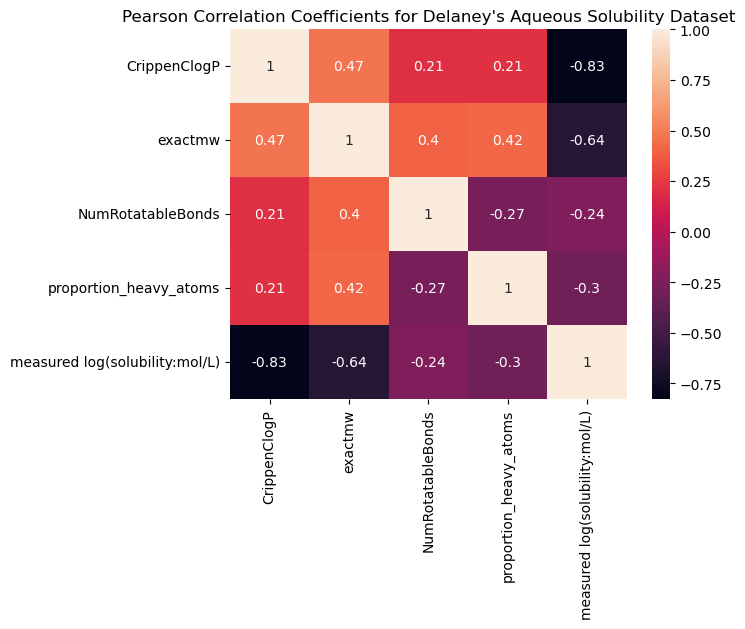

In [16]:
sns.heatmap(df_delaney_properties.corr(), annot=True)
plt.title("Pearson Correlation Coefficients for Delaney's Aqueous Solubility Dataset")

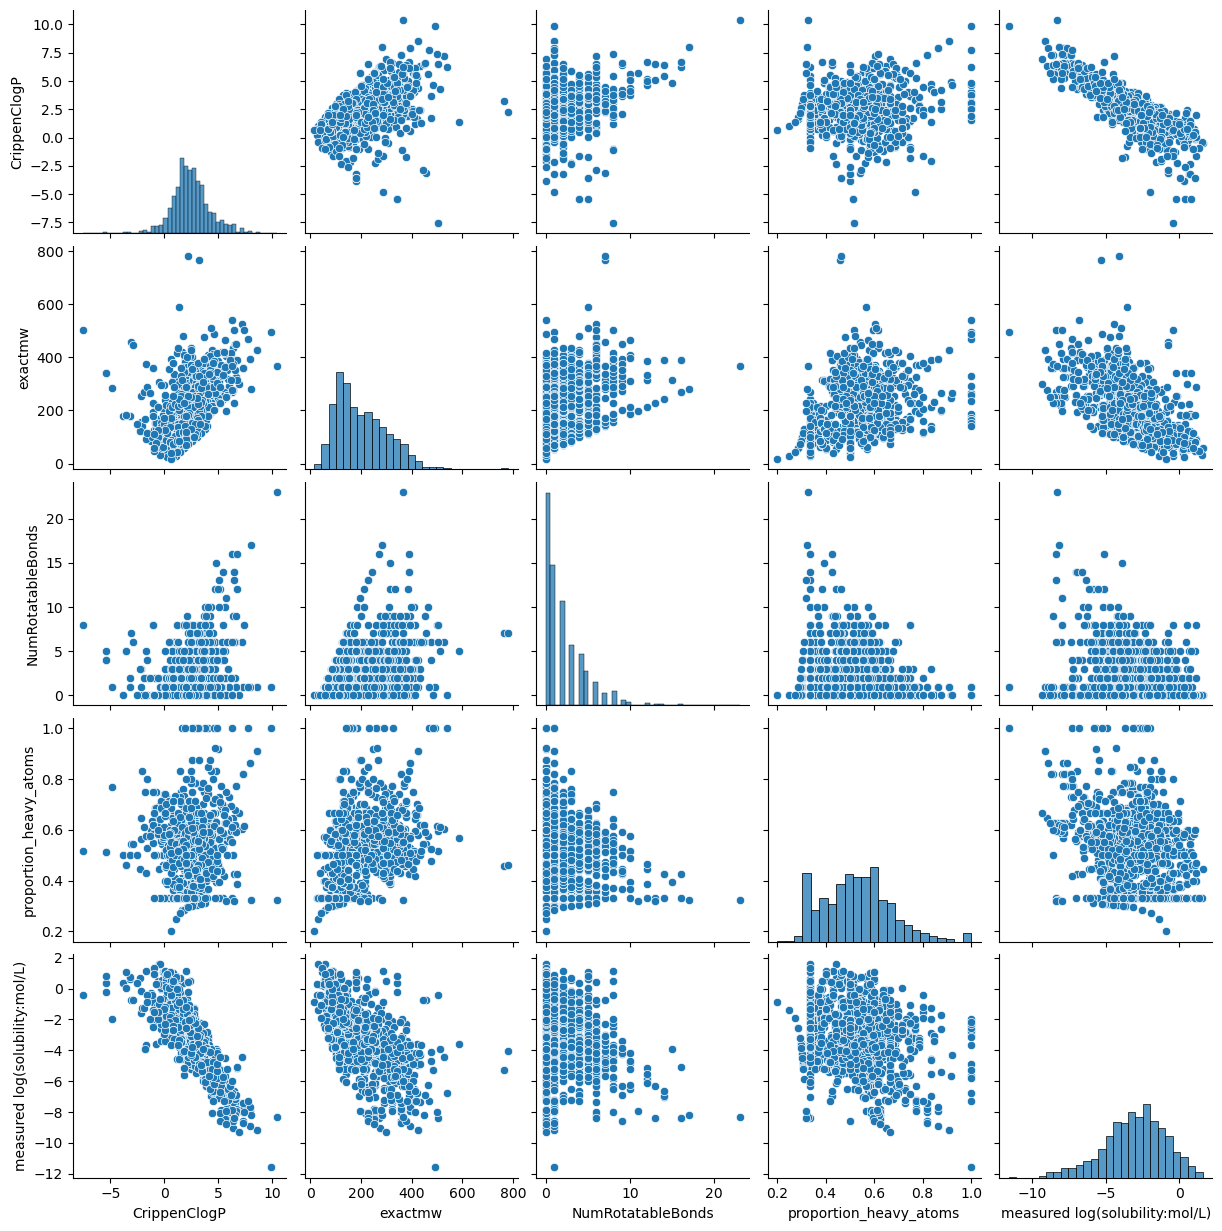

In [17]:
sns.pairplot(df_delaney_properties)

In [18]:
# training data
X = df_delaney_properties.drop(labels=['measured log(solubility:mol/L)'], axis=1).values

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import _regression

In [20]:
model = LinearRegression()

In [21]:
model.fit(X, y)

LinearRegression()

In [22]:
# r-squared value
model.score(X, y)

0.7665847697865419